<a href="https://colab.research.google.com/github/graphtrek/stockforecast/blob/main/graphtrek_08.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [525]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MAE
from tensorflow.keras.layers import Dense, Dropout
from tensorflow import keras
from datetime import datetime, timedelta
import pandas as pd
import os, time
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from sklearn.preprocessing import MinMaxScaler
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay
from keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MAE
from tensorflow.keras.layers import Dense, Dropout
from tensorflow import keras
from datetime import datetime, timedelta
import pandas as pd
import os, time
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
from sklearn.preprocessing import MinMaxScaler
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay
from keras.preprocessing.sequence import TimeseriesGenerator
from pathlib import Path

In [526]:
ticker = "VTI" # QQQ, SPY, VTI JETS, XLE, XLF, XLNX, ARKK, ARKG, ARKQ, ARKF, PYPL, V
look_back = 3 #  number of past days we want to use to predict 1 day in the future.
max_data_size = 730 # ~2 years
split_percent = 0.90 # use 90% of the data  for train
INFO = 1
DEBUG = 2
TRACE = 3
print_level = INFO 
indicators_model_file_path = '/content/drive/MyDrive/models/' + ticker + '_' + str(look_back) + '_indicators_08.h5'
nr_of_features = 3
look_forward = 1
epochs = 420
learning_rate=0.0042
if look_back < 5:
  num_prediction = look_back * 4
else:
  num_prediction = look_back * 2

apikey = '3F4URDEKOPLFH25T'
np.random.seed(42)

In [527]:
rsi_url = 'https://www.alphavantage.co/query?function=RSI&datatype=json&symbol='+ticker+'&interval=daily&time_period='+str(look_back)+'&series_type=close&apikey=' + apikey
print(rsi_url)
rsi_api_response = pd.read_json(rsi_url)
#print(rsi_api_response)
rsi_api_data = rsi_api_response['Technical Analysis: RSI']
#print(rsi_api_data)
rsi_api_data = rsi_api_data.drop(
    index=['1: Symbol','2: Indicator','3: Last Refreshed','4: Interval','5: Time Period','6: Series Type','7: Time Zone']);
#print(rsi_api_data)

rsi_data = []
for key, value in rsi_api_data.items():
  date = key
  rsi = float(value.get('RSI'))
  rsi_data.append([date,rsi])

last_rsi_data =  str(rsi_data[0])
first_rsi_data =  str(rsi_data[-1])
print('rsi_data_length:', len(rsi_data), 'first_rsi_data:', first_rsi_data, 'last_rsi_data:', last_rsi_data)  

https://www.alphavantage.co/query?function=RSI&datatype=json&symbol=VTI&interval=daily&time_period=3&series_type=close&apikey=3F4URDEKOPLFH25T
rsi_data_length: 5150 first_rsi_data: ['2001-06-05', 100.0] last_rsi_data: ['2021-11-19', 40.4515]


In [528]:
stoch_url = 'https://www.alphavantage.co/query?function=STOCH&symbol='+ticker+'&interval=daily&apikey=' + apikey
print(stoch_url)
stoch_api_response = pd.read_json(stoch_url)
stoch_api_data = stoch_api_response['Technical Analysis: STOCH']
#print(rsi_api_data)
stoch_api_data = stoch_api_data.drop(
    index=['1: Symbol','2: Indicator','3: Last Refreshed','4: Interval','5.1: FastK Period','5.2: SlowK Period','5.3: SlowK MA Type','5.4: SlowD Period','5.5: SlowD MA Type','6: Time Zone'])
#print(stoch_api_data)
stoch_data = []
for key, value in stoch_api_data.items():
  date = key
  SlowD = float(value.get('SlowD'))
  SlowK = float(value.get('SlowK'))
  stoch_data.append([date,SlowD,SlowK])

last_stoch_data =  str(stoch_data[0])
first_stoch_data =  str(stoch_data[-1])
print('stoch_data_length:', len(stoch_data), 'first_stoch_data:', first_stoch_data, 'last_stoch_data:', last_stoch_data)  

https://www.alphavantage.co/query?function=STOCH&symbol=VTI&interval=daily&apikey=3F4URDEKOPLFH25T
stoch_data_length: 5145 first_stoch_data: ['2001-06-12', 48.2257, 33.8565] last_stoch_data: ['2021-11-19', 63.0967, 50.4436]


In [529]:
stock_url = 'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY_ADJUSTED&symbol='+ticker+'&outputsize=full&apikey=' + apikey
print(stock_url)
stock_api_response = pd.read_json(stock_url)
stock_api_data = stock_api_response['Time Series (Daily)']
#print(stock_api_data)
stock_api_data = stock_api_data.drop(index=['1. Information','2. Symbol','3. Last Refreshed','4. Output Size','5. Time Zone']);

stock_data = []
split_coefficient = 1

for key, value in stock_api_data.items():
  date = key
  open = float(value.get('1. open'))
  high = float(value.get('2. high'))
  low = float(value.get('3. low'))
  close = float(value.get('4. close'))
  adjusted_close = float(value.get('5. adjusted close'))
  volume = int(value.get('6. volume'))
  divident = float(value.get('7. dividend amount'))

  if float(value.get('8. split coefficient')) > 1:
    split_coefficient = float(value.get('8. split coefficient'))
    
  open = open / split_coefficient
  high = high /split_coefficient
  close = close / split_coefficient
  low = low / split_coefficient
  
  stock_data.append([
      date,
      close,
      volume,
      high,
      low,
      open,
      divident
      ])

last_date =  str(stock_data[0][0])
print('data length:', len(stock_data), 'last_date:', last_date)

last_stock_data =  str(stock_data[0])
first_stock_data =  str(stock_data[-1])
print('stock_data_length:', len(stock_data), 'first_stock_data:', first_stock_data, 'last_stock_data:', last_stock_data)

https://www.alphavantage.co/query?function=TIME_SERIES_DAILY_ADJUSTED&symbol=VTI&outputsize=full&apikey=3F4URDEKOPLFH25T
data length: 5153 last_date: 2021-11-19
stock_data_length: 5153 first_stock_data: ['2001-05-31', 57.4, 2457200, 57.75, 57.25, 57.25, 0.0] last_stock_data: ['2021-11-19', 241.48, 3354681, 242.62, 241.3302, 242.09, 0.0]


In [530]:
data_size = np.min([len(rsi_data), len(stoch_data), len(stock_data)])
if max_data_size < data_size:
  rsi_data = np.flip(rsi_data[:max_data_size],axis=0)
  stoch_data = np.flip(stoch_data[:max_data_size],axis=0)
  stock_data = np.flip(stock_data[:max_data_size],axis=0)
else:
  rsi_data = np.flip(rsi_data[:data_size],axis=0)
  stoch_data = np.flip(stoch_data[:data_size],axis=0)
  stock_data = np.flip(stock_data[:data_size],axis=0)

dates = stock_data[:,0]

rsi_array = rsi_data[:,1]
stoch_slowD_array = stoch_data[:,1]
stoch_slowK_array = stoch_data[:,2]

indicators_data = np.append(np.expand_dims(dates, axis=1),  np.expand_dims(rsi_array, axis=1).astype(float),axis=1)
indicators_data = np.append(indicators_data, np.expand_dims(stoch_slowD_array, axis=1),axis=1)
indicators_data = np.append(indicators_data, np.expand_dims(stoch_slowK_array, axis=1),axis=1)
if print_level >= DEBUG:
  print('indicators_data',indicators_data[:5])

indicators_lstm_data = np.expand_dims(rsi_array, axis=1).astype(float)
indicators_lstm_data = np.append(indicators_lstm_data, np.expand_dims(stoch_slowD_array, axis=1),axis=1).astype(float)
indicators_lstm_data = np.append(indicators_lstm_data, np.expand_dims(stoch_slowK_array, axis=1),axis=1).astype(float)
if print_level >= DEBUG:
  print('indicators_lstm_data',indicators_lstm_data[:5])

In [531]:
stock_df = pd.DataFrame(stock_data,columns=['Date','Close','Volume','High','Low','Open','Divident'])
stock_df['50MA'] = stock_df['Close'].rolling(50).mean()
stock_df['100MA'] = stock_df['Close'].rolling(100).mean()
stock_df['200MA'] = stock_df['Close'].rolling(200).mean()

In [532]:
indicators_df = pd.DataFrame(indicators_data,columns=['Date','RSI','SlowD','SlowK'])
print(indicators_df)
split = int(split_percent*len(indicators_data))
if len(indicators_data) - split < look_back:
  split = look_back
split


indicators_df_train = indicators_df.iloc[:split]
indicators_df_test = indicators_df.iloc[split:]

indicators_lstm_train_data = indicators_lstm_data[:split]
indicators_lstm_test_data = indicators_lstm_data[split:]

           Date      RSI    SlowD    SlowK
0    2018-12-31  69.6546  68.1535  86.3548
1    2019-01-02  70.5548  82.2846  88.3185
2    2019-01-03  30.4501  83.8494   76.875
3    2019-01-04  68.2369  80.4448  76.1409
4    2019-01-07  74.7215  75.6623  73.9709
..          ...      ...      ...      ...
725  2021-11-15  65.7631  42.3776  52.2265
726  2021-11-16  78.9474  53.7572  73.0892
727  2021-11-17  50.7563  65.2288  70.3707
728  2021-11-18  59.0843  70.6453   68.476
729  2021-11-19  40.4515  63.0967  50.4436

[730 rows x 4 columns]


In [533]:
np.set_printoptions(formatter={'float': '{: 0.12f}'.format})

indicators_scaler = MinMaxScaler(feature_range=(0, 1))
indicators_scaler = indicators_scaler.fit(indicators_lstm_data)

indicators_lstm_train_data_scaled = indicators_scaler.transform(indicators_lstm_train_data)
if print_level >= TRACE:
  print(indicators_lstm_train_data_scaled[:look_back+1])
  print(indicators_lstm_train_data_scaled.shape)

indicators_lstm_test_data_scaled = indicators_scaler.transform(indicators_lstm_test_data)
if print_level >= TRACE:
  print(indicators_lstm_test_data_scaled[:look_back+1])
  print(indicators_lstm_test_data_scaled.shape)

In [534]:
indicators_train_generator = TimeseriesGenerator(indicators_lstm_train_data_scaled, indicators_lstm_train_data_scaled, sampling_rate=1, length=look_back, batch_size=64)

if print_level >= TRACE:
  print('Samples: %d' % len(indicators_train_generator))
  # print each sample
  for i in range(2):
    x, y = indicators_train_generator[i]
    print('%s => %s' % (x, y))

In [535]:
indicators_model = None
try:
  indicators_model = keras.models.load_model(indicators_model_file_path)
  modified = os.path.getmtime(indicators_model_file_path)

  print(pd.to_datetime(last_date).date() - datetime.fromtimestamp(modified).date() )
  print('Loaded', indicators_model_file_path , ' model train date:',datetime.fromtimestamp(modified).date() , 'last date:', last_date)
except:
  indicators_model = None
  print('Model ' + indicators_model_file_path + ' does not exists.')

Model /content/drive/MyDrive/models/VTI_3_indicators_08.h5 does not exists.


Model /content/drive/MyDrive/models/VTI_3_indicators_08.h5 compiled.
Saved model /content/drive/MyDrive/models/VTI_3_indicators_08.h5


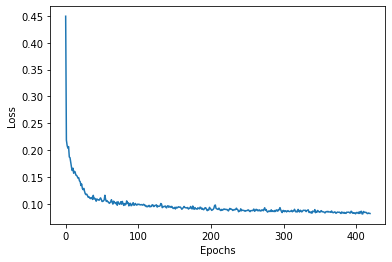

In [536]:
if indicators_model is None:
  indicators_model = Sequential()
  indicators_model.add(LSTM(units=42, activation='tanh', input_shape=(look_back, nr_of_features), return_sequences=True))
  indicators_model.add(Dropout(0.2))
  indicators_model.add(LSTM(units=42, return_sequences=True, activation="relu"))
  indicators_model.add(Dropout(0.2))
  indicators_model.add(LSTM(units=42, return_sequences=True, activation="relu"))
  indicators_model.add(Dropout(0.2))
  indicators_model.add(LSTM(units=42, activation="tanh"))
  indicators_model.add(Dropout(0.2))
  indicators_model.add(Dense(nr_of_features))

  indicators_model.compile(
      loss=MAE,
      optimizer=Adam(learning_rate=learning_rate),
      metrics=['mae','mse']
  )
    
  #model.summary()
  print('Model ' + indicators_model_file_path + ' compiled.')

  indicators_modelo = indicators_model.fit(indicators_train_generator, epochs=epochs, verbose=0 )
  
  indicators_model.save(indicators_model_file_path)
  print('Saved model ' + indicators_model_file_path)

  
  plt.plot(indicators_modelo.history['loss'])
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.show()

In [537]:
indicators_test_generator = TimeseriesGenerator(indicators_lstm_test_data_scaled, indicators_lstm_test_data_scaled,sampling_rate=1, length=look_back, batch_size=look_back)

print('Samples: %d' % len(indicators_test_generator))
# print each sample
if print_level >= TRACE:
  for i in range(2):
    x, y = indicators_test_generator[i]
    print('%s => %s' % (x, y))

Samples: 24


In [538]:
#Make prediction
indicators_prediction_scaled = indicators_model.predict(indicators_test_generator)

if print_level >= DEBUG:
  np.set_printoptions(formatter={'float': '{: 0.12f}'.format})
  print(indicators_prediction_scaled[:5])

indicators_prediction = indicators_scaler.inverse_transform(indicators_prediction_scaled)
if nr_of_features == 1:
   rsi_prediction = indicators_prediction.reshape((-1))
else:
  rsi_prediction = indicators_prediction[:,0].reshape((-1))
  stoch_slowD_prediction = indicators_prediction[:,1].reshape((-1))
  stoch_slowK_prediction = indicators_prediction[:,2].reshape((-1))

if print_level >= DEBUG:
  np.set_printoptions(formatter={'float': '{: 0.2f}'.format})
  print('indicators_prediction shape:',indicators_prediction.shape)

  for x in range(look_back + 1):
    print('pred:',indicators_prediction[x], 'test:', indicators_lstm_test_data[x])


In [539]:
def predict(num_prediction, model):
    prediction_list = indicators_lstm_test_data_scaled[-look_back:]
    #print('prediction_list',prediction_list)
    for _ in range(num_prediction):
        x = prediction_list[-look_back:]
        #print(x)
        x = x.reshape((1, look_back, nr_of_features))
        out = model.predict(x)
        #print(x,out) 
        prediction_list = np.append(prediction_list, out, axis=0)
    prediction_list = prediction_list[look_back-1:]
        
    return prediction_list
    
def predict_dates(last_date,num_prediction):
    us_bd = CustomBusinessDay(calendar=USFederalHolidayCalendar())
    prediction_dates = pd.date_range(last_date, periods=num_prediction+1,freq=us_bd).tolist()
    return prediction_dates

indicators_forecast_scaled = predict(num_prediction, indicators_model)
#print(forecast_scaled)
indicators_forecast_dates = predict_dates(indicators_df['Date'].values[-1],num_prediction)

indicators_forecast = indicators_scaler.inverse_transform(indicators_forecast_scaled.reshape((-1,nr_of_features)))
if nr_of_features == 1:
   rsi_forecast = indicators_forecast.reshape((-1))
else:
  rsi_forecast = indicators_forecast[:,0].reshape((-1))
  stoch_SlowD_forecast = indicators_forecast[:,1].reshape((-1))
  stoch_SlowK_forecast = indicators_forecast[:,2].reshape((-1))

if print_level >= DEBUG:
  print('indicators_forecast:',indicators_forecast)
  print('rsi_forecast:',rsi_forecast)

In [540]:
chart_days = len(indicators_df_test) * 2

#'Date','Close','Volume','High','Low','Open','Divident'
open_price =  str(stock_data[-1][5])
low_price =  str(stock_data[-1][3])
high_price =  str(stock_data[-1][4])
close_price =  str(stock_data[-1][1])
rsi_forecast_mean = np.round(np.mean(rsi_forecast))

tradingview_link = '<a href="https://in.tradingview.com/chart/66XmQfYy/?symbol=' + ticker +'">' + ticker +'</a>'
stock_title = tradingview_link + ' Date:' + last_date + ' Open:' + open_price + ' High:' + high_price + ' Low:' + low_price + ' Close:' + close_price
indicators_title = tradingview_link + ' RSI('+ str(look_back)+ ') Date:' + last_date + ' Close:' + indicators_df['RSI'].iloc[-1] + ' Forecast('+str(look_back)+'):' + str(rsi_forecast_mean)

fig = make_subplots(rows=3, cols=1, row_heights=[0.4, 0.3, 0.3], subplot_titles=(stock_title, indicators_title))

go.Layout(
    title = ticker + ' Date:' + last_date + ' Open:' + open_price + ' High:' + high_price + ' Low:' + low_price + ' Close:' + close_price,
    xaxis = {'title' : "Dates"},
    yaxis = {'title' : "Close Price ($)"},
    height = 450
)

trace1 = go.Candlestick(
    x = stock_df.tail(chart_days)['Date'],
    open = stock_df.tail(chart_days)['Open'],
    high = stock_df.tail(chart_days)['High'],
    low = stock_df.tail(chart_days)['Low'],
    close = stock_df.tail(chart_days)['Close'],
    name = ticker + ' Price'
)

trace2 = go.Scatter(
    x = stock_df.tail(chart_days)['Date'],
    y = stock_df.tail(chart_days)['50MA'],
    mode='lines',
    name ='50MA'
)

trace3 = go.Scatter(
    x = stock_df.tail(chart_days)['Date'],
    y = stock_df.tail(chart_days)['100MA'],
    mode='lines',
    name ='100MA'
)

trace4 = go.Scatter(
    x = stock_df.tail(chart_days)['Date'],
    y = stock_df.tail(chart_days)['200MA'],
    mode='lines',
    name ='200MA'
)

fig.add_trace(trace1,row=1, col=1)
fig.add_trace(trace2,row=1, col=1)
fig.add_trace(trace3,row=1, col=1)
fig.add_trace(trace4,row=1, col=1)

trace_rsi_train = go.Scatter(
  x = indicators_df_train.tail(len(indicators_df_test))['Date'],
  y = indicators_df_train.tail(len(indicators_df_test))['RSI'],
  mode='lines',
  name ='RSI'
)

trace_rsi_test = go.Scatter(
  x = indicators_df_test['Date'],
  y = indicators_df_test['RSI'],
  mode='lines',
  name ='Test'
)

trace_rsi_prediction = go.Scatter(
    x = indicators_df_test['Date'],
    y = rsi_prediction,
    mode='markers+lines',
    name ='Prediction'
)

trace_rsi_forecast = go.Scatter(
    x = indicators_forecast_dates,
    y = rsi_forecast,
    mode='markers+lines',
    name ='Forecast'
)

fig.add_trace(trace_rsi_train,row=2, col=1)
fig.add_trace(trace_rsi_test,row=2, col=1)
fig.add_trace(trace_rsi_prediction,row=2, col=1)
fig.add_trace(trace_rsi_forecast,row=2, col=1)

fig.add_trace(go.Scatter(
        x = [indicators_df_train.tail(len(indicators_df_test))['Date'].min(), np.max(indicators_forecast_dates)],
        y = [70, 70],
        mode = "lines",
        line = dict(shape = 'linear', color = 'rgb(100, 10, 100)', dash = 'dash')
    ),row=2, col=1)

fig.add_trace(go.Scatter(
        x = [indicators_df_train.tail(len(indicators_df_test))['Date'].min(), np.max(indicators_forecast_dates)],
        y = [50, 50],
        mode = "lines",
        line = dict(shape = 'linear', color = 'rgb(10, 12, 240)', dash = 'dash')
    ),row=2, col=1)

fig.add_trace(go.Scatter(
        x = [indicators_df_train.tail(len(indicators_df_test))['Date'].min(), np.max(indicators_forecast_dates)],
        y = [30, 30],
        mode = "lines",
        line = dict(shape = 'linear', color = 'rgb(10, 120, 24)', dash = 'dash')
    ),row=2, col=1)


trace_stoch_SlowK_train = go.Scatter(
  x = indicators_df_train.tail(len(indicators_df_test))['Date'],
  y = indicators_df_train.tail(len(indicators_df_test))['SlowK'],
  mode='lines',
  name ='Train Stoch SlowK'
)

trace_stoch_SlowD_train = go.Scatter(
  x = indicators_df_train.tail(len(indicators_df_test))['Date'],
  y = indicators_df_train.tail(len(indicators_df_test))['SlowD'],
  mode='lines',
  name ='Train Stoch SlowD'
)

trace_stoch_SlowD_test = go.Scatter(
  x = indicators_df_test['Date'],
  y = indicators_df_test['SlowD'],
  mode='lines',
  name ='Test Stoch SlowD'
)

trace_stoch_SlowK_test = go.Scatter(
  x = indicators_df_test['Date'],
  y = indicators_df_test['SlowK'],
  mode='lines',
  name ='Test Stoch SlowK'
)

trace_stoch_SlowD_prediction = go.Scatter(
    x = indicators_df_test['Date'],
    y = stoch_slowD_prediction,
    mode='markers+lines',
    name ='Prediction Stoch SlowD'
)

trace_stoch_SlowK_prediction = go.Scatter(
    x = indicators_df_test['Date'],
    y = stoch_slowK_prediction,
    mode='markers+lines',
    name ='Prediction Stoch SlowK'
)

trace_stoch_SlowD_forecast = go.Scatter(
    x = indicators_forecast_dates,
    y = stoch_SlowD_forecast,
    mode='markers+lines',
    name ='Forecast Stoch SlowD'
)

trace_stoch_SlowK_forecast = go.Scatter(
    x = indicators_forecast_dates,
    y = stoch_SlowK_forecast,
    mode='markers+lines',
    name ='Forecast Stoch SlowK'
)

fig.add_trace(trace_stoch_SlowK_train, row=3,col=1 )
fig.add_trace(trace_stoch_SlowD_train, row=3,col=1 )
fig.add_trace(trace_stoch_SlowD_test, row=3,col=1 )
fig.add_trace(trace_stoch_SlowK_test, row=3,col=1 )
fig.add_trace(trace_stoch_SlowD_prediction, row=3,col=1 )
fig.add_trace(trace_stoch_SlowK_prediction, row=3,col=1 )
fig.add_trace(trace_stoch_SlowD_forecast, row=3,col=1 )
fig.add_trace(trace_stoch_SlowK_forecast, row=3,col=1 )

fig.add_trace(go.Scatter(
        x = [indicators_df_train.tail(len(indicators_df_test))['Date'].min(), np.max(indicators_forecast_dates)],
        y = [70, 70],
        mode = "lines",
        line = dict(shape = 'linear', color = 'rgb(100, 10, 100)', dash = 'dash')
    ),row=3, col=1)

fig.add_trace(go.Scatter(
        x = [indicators_df_train.tail(len(indicators_df_test))['Date'].min(), np.max(indicators_forecast_dates)],
        y = [50, 50],
        mode = "lines",
        line = dict(shape = 'linear', color = 'rgb(10, 12, 240)', dash = 'dash')
    ),row=3, col=1)

fig.add_trace(go.Scatter(
        x = [indicators_df_train.tail(len(indicators_df_test))['Date'].min(), np.max(indicators_forecast_dates)],
        y = [30, 30],
        mode = "lines",
        line = dict(shape = 'linear', color = 'rgb(10, 120, 24)', dash = 'dash')
    ),row=3, col=1)

fig.update_yaxes(showspikes=True, spikemode='across', spikesnap='cursor',spikedash='dash')
fig.update_xaxes(showspikes=True, spikemode='across', spikesnap='cursor', spikedash='dash')
fig.update_layout(xaxis_rangeslider_visible=False,height=650)

fig.show()
folder='/content/drive/MyDrive/models/charts/'+ last_date
Path(folder).mkdir(parents=True, exist_ok=True)
print('chart folder:', folder)
fig.write_html(folder + '/' + ticker + '_' + str(look_back) + '_08_inidicators_forecast.html')

chart folder: /content/drive/MyDrive/models/charts/2021-11-19
